Lösen Sie das Anfangswertproblem

$\begin{align}
    u^\prime          & = u + v \\
    \epsilon v^\prime & = 2 u - v
\end{align}$

mit Anfangswerten $(u(0), v(0)) = (1, 4)$ mithilfe des Radau-IIA Verfahrens, eines Gauß-Verfahrens und des RK4-Verfahrens numerisch für unterschiedliche $\epsilon > 0$. Verwenden Sie dabei Verfahren, die vergleichbare Konvergenzordnungen besitzen. Untersuchen Sie die Abhängikeit des komponentenweisen Fehlers an der Stelle $t = 0.1$ vom Parameter $\epsilon$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sympy as sp

In [2]:
def Radau_IIA():

    """
        returns the butcher table of the 2-stage Radau method
        consistency order ... 3
    """
    
    c = np.array([1/3, 1])
    A = np.array([[5/12, -1/12],
                  [3/4,   1/4 ]])
    b = np.array([3/4, 1/4])
    
    return c, A, b

def Gauss():
    
    """
        returns the butcher table of the 2-stage Gauss method
        consistency order ... 4
    """
    
    sqrt = np.sqrt(3)/6
    
    c = np.array([1/2 - sqrt, 1/2 + sqrt])
    A = np.array([[1/4,        1/4 - sqrt],
                  [1/4 + sqrt, 1/4       ]])
    b = np.array([1/2, 1/2])
    
    return c, A, b

def RK4():
    
    """
        returns the butcher table of the 2-stage Gauss method
        consistency order ... 4
    """

    c = np.array([0, 1/2, 1/2, 1])
    A = np.array([[0,   0,   0, 0],
                  [1/2, 0,   0, 0],
                  [0,   1/2, 0, 0],
                  [0,   0,   1, 0]])
    b = np.array([1/6, 1/3, 1/3, 1/6])
    
    return c, A, b

In [3]:
def get_f(epsilon):

    """
        returns the function f_\epsilon
    """
    
    f = lambda t, y: np.array([y[0] + y[1], (2 * y[0] - y[1]) / epsilon])
    
    return f

In [4]:
def explicit_RK(f, y_0, t, butcher_tableau):
    
    """
        applies an explicit Runge-Kutta-Method
        returns approximation vector
        f ..... right hand side of ODE
                (should return numpy array)
        y_0 ... initial value of ODE
                (should be numpy array)
        t ..... time stamps, where to approximate
    """
    
    c, A, b = butcher_tableau
    m = len(c)
    
    # dimension of ODE
    n = len(y_0)
    
    # time steps
    h = t[1::] - t[:-1:]

    # number of time steps
    N = len(h)

    # potential approximation vector
    y = np.zeros((N+1, n))
    y[0] = y_0
    
    for ell in range(N):
        
        # increments
        k = np.zeros((m, n))
        
        for i in range(m):
            
            t_ = t[ell] + c[i] * h[ell]
            y_ = y[ell] + h[ell] * np.sum([A_ * k_ for A_, k_ in zip(A[i, :i-1:], k[:, :i-1:])])

            k[i] = f(t_, y_)
            
        Phi = np.sum([b_ * k_ for b_, k_ in zip(b, k)])
        y[ell + 1] = y[ell] + h[ell] * Phi
    
    return y.transpose()

In [5]:
def implicit_RK(f, y_0, t, butcher_tableau):

    """
        applies an explicit Runge-Kutta-Method
        returns approximation vector
        f ..... right hand side of ODE
                (should return numpy array)
        y_0 ... initial value of ODE
                (should be numpy array)
        t ..... time stamps, where to approximate
    """

    c, A, b = butcher_tableau
    m = len(c)

    # dimension of ODE
    n = len(y_0)

    # time steps
    h = t[1::] - t[:-1:]

    # number of time steps
    N = len(h)

    # potential approximation vector
    y = np.zeros((N+1, n))
    y[0] = y_0

    for ell in range(N):

        def F(k_vector):
            
            """
               Function that should be 0 for the correct increments,
               written as m*n vector (not matrix), as input
            """
            
            k_matrix = k_vector.reshape((m, n))

            residuum = np.zeros((m, n))
            for i in range(m):

                t_ = t[ell] + c[i] * h[ell]
                y_ = y[ell] + h[ell] * np.sum([A_ * k_ for A_, k_ in zip(A[i, :], k_matrix)])

                residuum[i] = k_matrix[i] - f(t_, y_)

            return residuum.flatten()

        # laut Aufgabe 34
        guess = np.array([f(t[ell], y[ell])]*n).flatten()

        # increments
        k = fsolve(F, guess)

        Phi = np.sum([b_ * k_ for b_, k_ in zip(b, k)])
        y[ell + 1] = y[ell] + h[ell] * Phi

    return y.transpose()

In [6]:
def plot_ODE(t, y, title = 'Hier könnte Ihre Werbung stehen!'):

    """
        plots (approximation of) solution of ODE
        t ... time
        y ... solutions (as matrix)
    """

    fig = plt.figure()

    for i, y_ in enumerate(y):
        plt.plot(t, y_, label = '$y_{}$'.format(i+1))

    plt.xlabel('$t$')
    plt.ylabel('$y$')
    plt.legend()
    plt.suptitle(title)

    plt.grid(linestyle = ':')
    plt.show()

In [7]:
epsilon_array = np.array([10**p for p in range(-16, 17)])

error_RK4       = []
error_Radau_IIA = []
error_Gauss     = []

y_0 = np.array([1, 4])

epsilon = sp.Symbol('epsilon')
A = sp.Matrix([[1,          1],
               [2/epsilon, -1/epsilon]])
t = sp.Symbol('t')

solution = sp.exp(t*A) @ sp.Matrix(list(y_0))
solution = sp.lambdify([epsilon, t], solution)

t = np.linspace(0, 1, 1000)

print('#', '-'*64, '#', '\n')

# ---------------- #

for epsilon in epsilon_array:

    print('epsilon =', epsilon, '\n')

    f = get_f(epsilon)

    # ---------------- #

    # Analytic Solution
    title = 'Analytic Solution'
    y_1, y_2 = solution(epsilon, t)
    y = np.array([y_1[0], y_2[0]])
#     plot_ODE(t, y, title)

    last_value_analytic_solution = y[:, -1]

    # ---------------- #

    # RK4
    title = 'RK4'
    butcher_tableau = RK4()
    y = explicit_RK(f, y_0, t, butcher_tableau)
#     plot_ODE(t, y, title)

    last_value_RK4 = y[:, -1]
    error_RK4 += [abs(last_value_analytic_solution - last_value_RK4)]

    # Radau_IIA
    title = 'Radau_IIA'
    butcher_tableau = Radau_IIA()
    y = implicit_RK(f, y_0, t, butcher_tableau)
#     plot_ODE(t, y, title)

    last_value_Radau_IIA = y[:, -1]
    error_Radau_IIA += [abs(last_value_analytic_solution - last_value_Radau_IIA)]

    # Gauss
    title = 'Gauss'
    butcher_tableau = Gauss()
    y = implicit_RK(f, y_0, t, butcher_tableau)
#     plot_ODE(t, y, title)
    
    last_value_Gauss = y[:, -1]
    error_Gauss += [abs(last_value_analytic_solution - last_value_Gauss)]

    print('#', '-'*64, '#', '\n')

# ---------------- #

error_RK4       = np.array(error_Gauss).transpose()
error_Radau_IIA = np.array(error_Radau_IIA).transpose()
error_Gauss     = np.array(error_Gauss).transpose()

# ---------------------------------------------------------------- # 

epsilon = 1e-16 



<string>:2: RuntimeWarning: invalid value encountered in true_divide
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply
C:\Users\richa\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\richa\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


# ---------------------------------------------------------------- # 

epsilon = 1e-15 

# ---------------------------------------------------------------- # 

epsilon = 1e-14 

# ---------------------------------------------------------------- # 

epsilon = 1e-13 

# ---------------------------------------------------------------- # 

epsilon = 1e-12 

# ---------------------------------------------------------------- # 

epsilon = 1e-11 

# ---------------------------------------------------------------- # 

epsilon = 1e-10 

# ---------------------------------------------------------------- # 

epsilon = 1e-09 

# ---------------------------------------------------------------- # 

epsilon = 1e-08 

# ---------------------------------------------------------------- # 

epsilon = 1e-07 

# ---------------------------------------------------------------- # 

epsilon = 1e-06 

# ---------------------------------------------------------------- # 

epsilon = 1e-05 

# -------------------

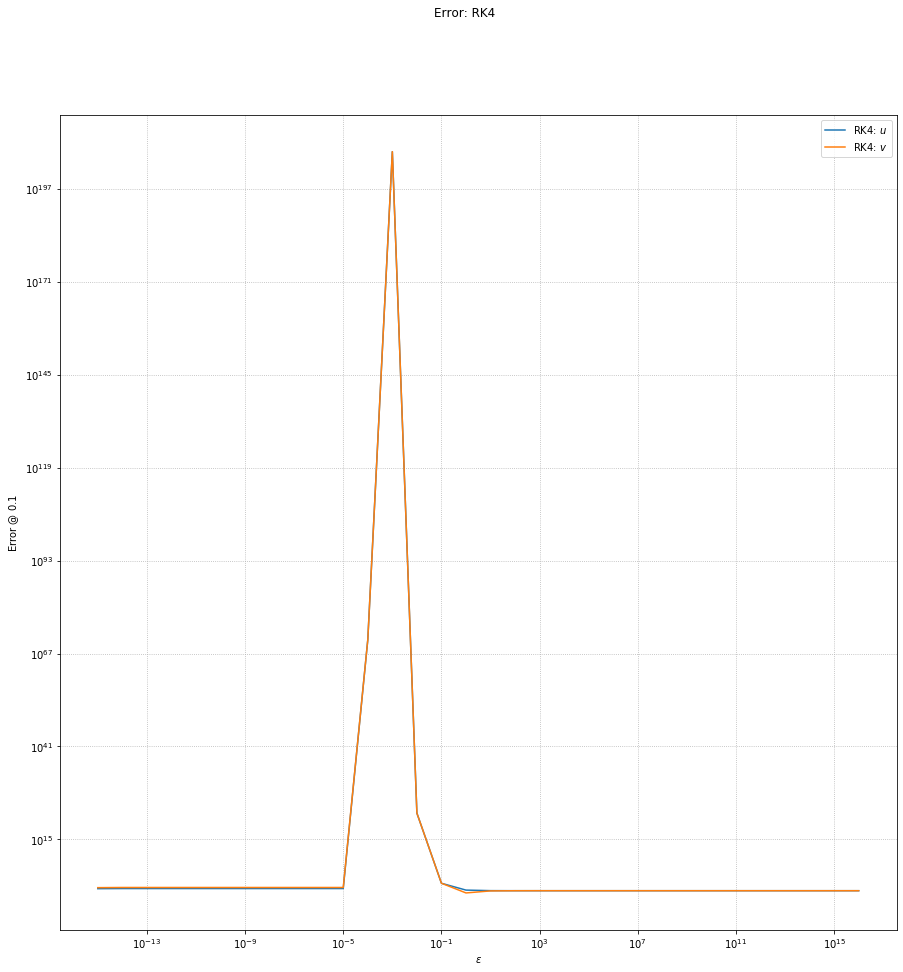

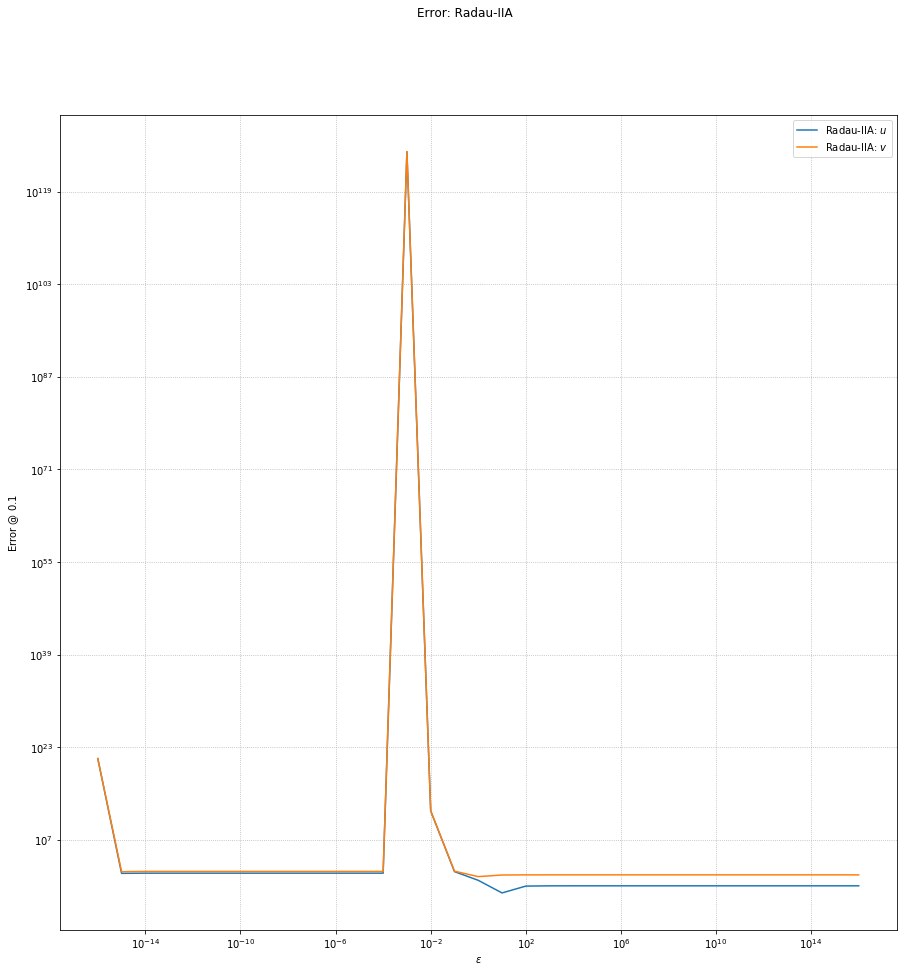

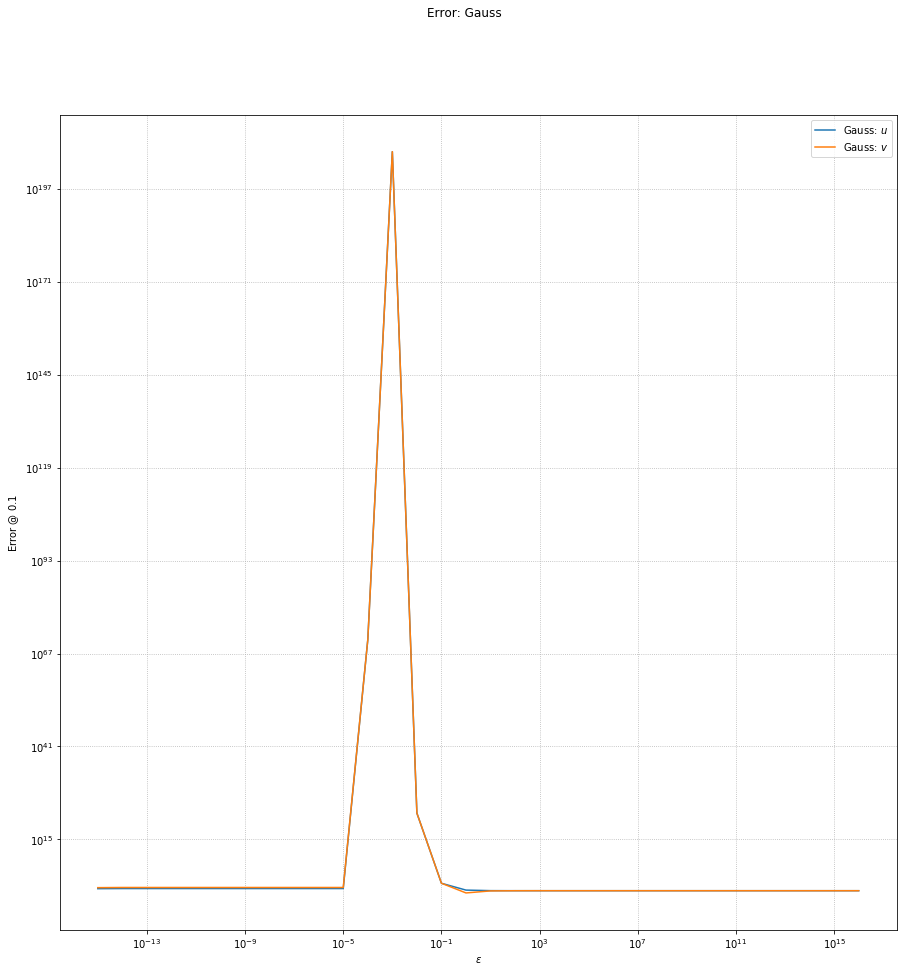

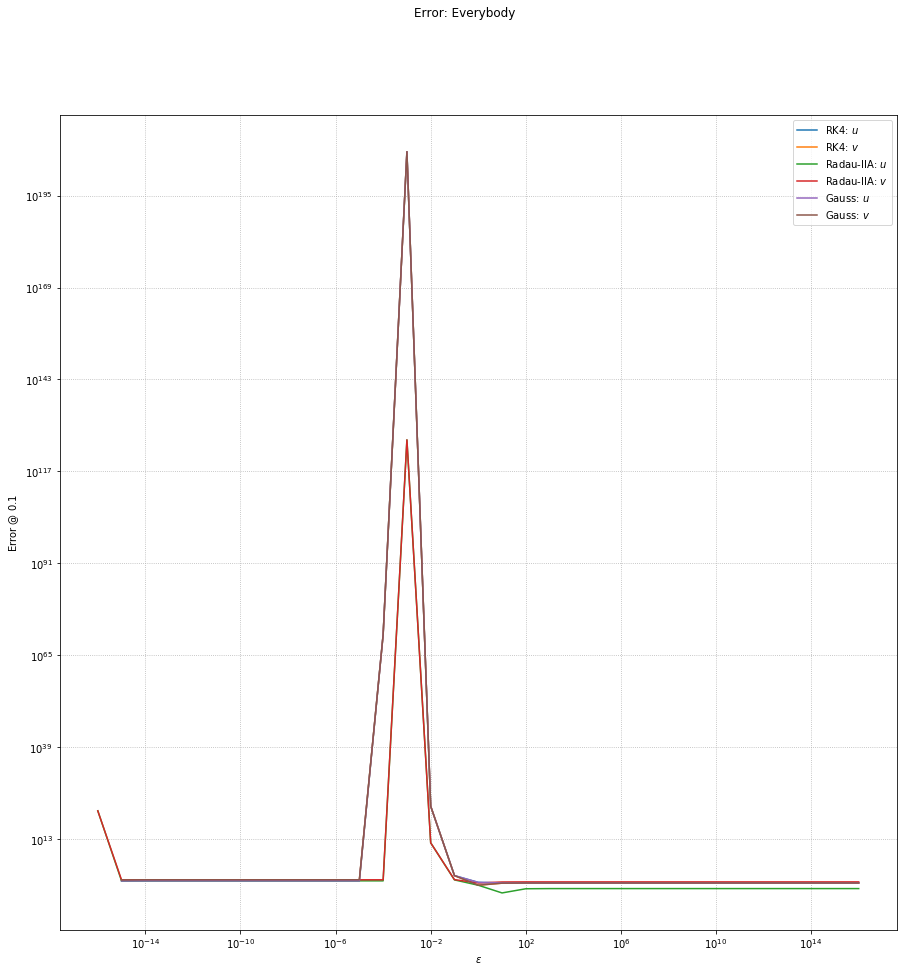

In [8]:
# ---------------- #

fig = plt.figure(figsize = (15, 15))

plt.loglog(epsilon_array, error_RK4[0],       label = 'RK4'       + ': ' + '$u$')
plt.loglog(epsilon_array, error_RK4[1],       label = 'RK4'       + ': ' + '$v$')

plt.xlabel('$\epsilon$')
plt.ylabel('Error @ $0.1$')
plt.legend()
plt.suptitle('Error:' + ' ' + 'RK4')

plt.grid(linestyle = ':')
plt.show()

# ---------------- #

fig = plt.figure(figsize = (15, 15))

plt.loglog(epsilon_array, error_Radau_IIA[0], label = 'Radau-IIA' + ': ' + '$u$')
plt.loglog(epsilon_array, error_Radau_IIA[1], label = 'Radau-IIA' + ': ' + '$v$')

plt.xlabel('$\epsilon$')
plt.ylabel('Error @ $0.1$')
plt.legend()
plt.suptitle('Error:' + ' ' + 'Radau-IIA')

plt.grid(linestyle = ':')
plt.show()

# ---------------- #

fig = plt.figure(figsize = (15, 15))

plt.loglog(epsilon_array, error_Gauss[0],     label = 'Gauss'     + ': ' + '$u$')
plt.loglog(epsilon_array, error_Gauss[1],     label = 'Gauss'     + ': ' + '$v$')

plt.xlabel('$\epsilon$')
plt.ylabel('Error @ $0.1$')
plt.legend()
plt.suptitle('Error:' + ' ' + 'Gauss')

plt.grid(linestyle = ':')
plt.show()

# ---------------- #

fig = plt.figure(figsize = (15, 15))

plt.loglog(epsilon_array, error_RK4[0],       label = 'RK4'       + ': ' + '$u$')
plt.loglog(epsilon_array, error_RK4[1],       label = 'RK4'       + ': ' + '$v$')
plt.loglog(epsilon_array, error_Radau_IIA[0], label = 'Radau-IIA' + ': ' + '$u$')
plt.loglog(epsilon_array, error_Radau_IIA[1], label = 'Radau-IIA' + ': ' + '$v$')
plt.loglog(epsilon_array, error_Gauss[0],     label = 'Gauss'     + ': ' + '$u$')
plt.loglog(epsilon_array, error_Gauss[1],     label = 'Gauss'     + ': ' + '$v$')

plt.xlabel('$\epsilon$')
plt.ylabel('Error @ $0.1$')
plt.legend()
plt.suptitle('Error:' + ' ' + 'Everybody')

plt.grid(linestyle = ':')
plt.show()